# UAS Proyek Sains Data: Klasifikasi Digit Tulisan Tangan (PenDigits)


## 1. Business Understanding

* **Latar Belakang Masalah:**
    Pengenalan tulisan tangan (*Handwritten Digit Recognition*) menjadi fitur krusial dalam digitalisasi dokumen dan antarmuka perangkat layar sentuh. Tantangan utamanya adalah variasi gaya penulisan (*stroke*) antar individu yang berbeda-beda, sehingga diperlukan model yang mampu mengenali pola gerakan pena secara akurat.
* **Tujuan Proyek:**
    1.  Membangun model klasifikasi yang mampu memprediksi angka (0-9) berdasarkan data urutan koordinat (Time Series) dengan akurasi tinggi.
    2.  Mengembangkan *prototype* aplikasi berbasis web di mana pengguna dapat menulis angka pada layar dan sistem memprediksinya secara *real-time*.
* **Metrik Keberhasilan:**
    * **Teknis:** Akurasi model > 95% pada data uji.
    * **Bisnis:** Aplikasi dapat menangkap input coretan user, mengonversinya menjadi 8 titik sampel, dan memprediksi angka dengan benar.



## 2. Data Understanding

* **Sumber Data & Referensi:**
    * Dataset: **PenDigits** (Pen-Based Recognition of Handwritten Digits).
    * Paper Asli: *F. Alimoglu & E. Alpaydin (1996). Combining Multiple Representations and Classifiers for Pen-Based Handwritten Digit Recognition.*
    * Terdapat 10 kelas yaitu angka 0 sampai 9
    * Terdapat 2 fitur yaitu dimensi 0 dan dimensi 1, dimensi 0 adalah kordinat sumbu x dan dimensi 1 adalah kordinat sumbu y

* **Proses Akuisisi Data (Data Generation Process):**
    Berdasarkan jurnal referensi, data ini diperoleh melalui tahapan berikut:
    1.  **Subjek:** Data dikumpulkan dari **44 penulis** yang berbeda.
    2.  **Perangkat:** Penulis diminta menulis angka 0-9 menggunakan tablet sensitif tekanan (**Wacom PL-100V**).
    3.  **Raw Input:** Saat pena bergerak di atas tablet, perangkat merekam koordinat $(x_t, y_t)$ dengan frekuensi sampling 100 milidetik.
    4.  **Masalah Awal:** Karena kecepatan menulis setiap orang berbeda, jumlah titik koordinat yang terekam bervariasi (variable length).

* **Transformasi ke Time Series (Feature Extraction):**
    Agar dapat diproses oleh model, data mentah diubah menjadi format baku melalui langkah-langkah yang dilakukan oleh peneliti asli:
    1.  **Normalisasi:** Seluruh koordinat dinormalisasi agar masuk ke dalam kotak ukuran **100x100 pixel**. Ini agar ukuran tulisan (besar/kecil) tidak mempengaruhi hasil.
    2.  **Spatial Resampling :** Data deret waktu mentah di-resampling bukan berdasarkan waktu, melainkan berdasarkan **jarak spasial**.
    3.  **Fixed Length:** Algoritma memilih **8 titik ekuidistan** (berjarak sama) di sepanjang alur goresan pena.
    4.  **Hasil Akhir:** Setiap sampel data terdiri dari urutan **8 pasang koordinat (x,y)**. Inilah yang membuat data ini disebut sebagai *Multivariate Time Series* dengan panjang series 8.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
from sktime.datasets import load_from_tsfile
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:

# ==========================================
# 1. BUSINESS & DATA UNDERSTANDING
# ==========================================
print("--- 1. LOADING DATA ---")

# Load Data Asli (Original Split)
X_train, y_train = load_from_tsfile("PenDigits_TRAIN.ts")
X_test, y_test = load_from_tsfile("PenDigits_TEST.ts")

# Menampilkan Dataset dalam bentuk Tabel (DataFrame)
print("\n[INFO] Menampilkan 5 sampel pertama dari Data Training:")
# Kita konversi sedikit agar terlihat rapi di output notebook
display(X_train.head())

print(f"\nDimensi X_train: {X_train.shape}")
print(f"Dimensi X_test : {X_test.shape}")

--- 1. LOADING DATA ---



[INFO] Menampilkan 5 sampel pertama dari Data Training:


,dim_0,dim_1
0,0 47.0 1 27.0 2 57.0 3 26.0 4 ...,0 100.0 1 81.0 2 37.0 3 0.0 4 ...
1,0 0.0 1 27.0 2 42.0 3 29.0 4 ...,0 89.0 1 100.0 2 75.0 3 45.0 4 ...
2,0 0.0 1 31.0 2 72.0 3 100.0 4 ...,0 57.0 1 68.0 2 90.0 3 100.0 4 ...
3,0 0.0 1 7.0 2 5.0 3 19.0 4 ...,0 100.0 1 92.0 2 68.0 3 45.0 4 ...
4,0 0.0 1 49.0 2 100.0 3 81.0 4 ...,0 67.0 1 83.0 2 100.0 3 80.0 4 ...



Dimensi X_train: (7494, 2)
Dimensi X_test : (3498, 2)



--- ANALISIS MENDALAM: BENTUK RATA-RATA (MEAN SHAPE) ---


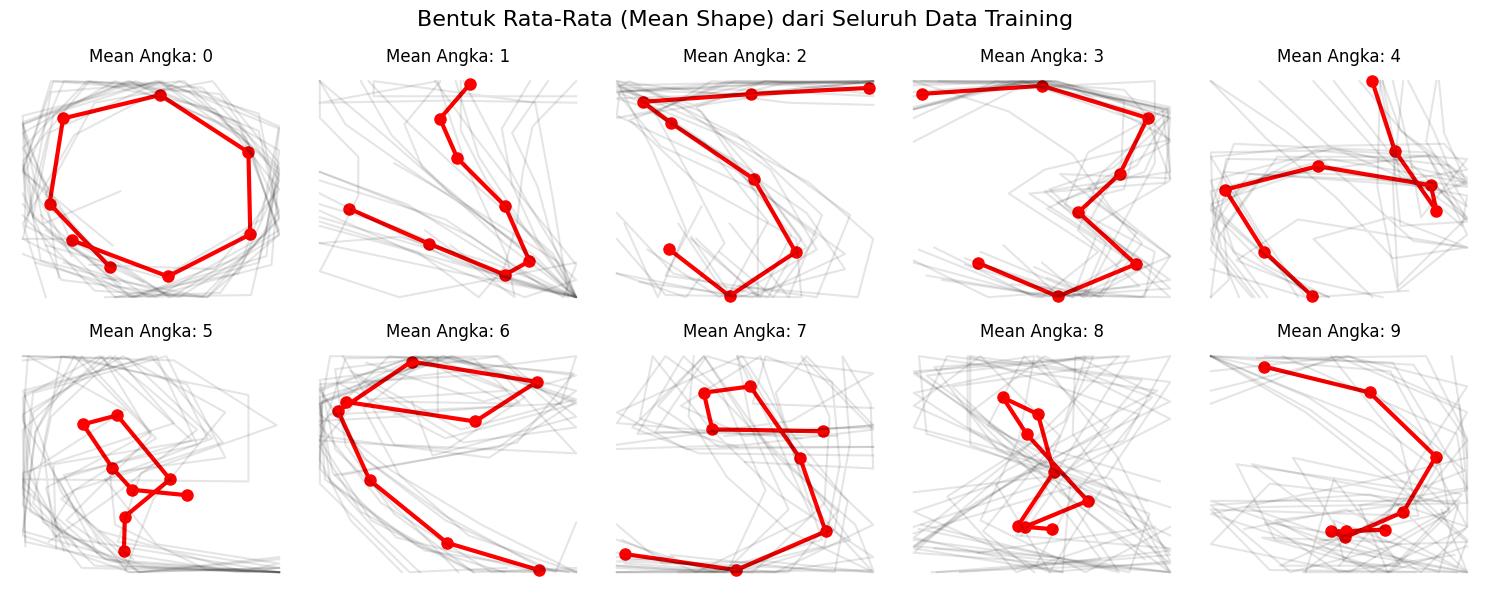

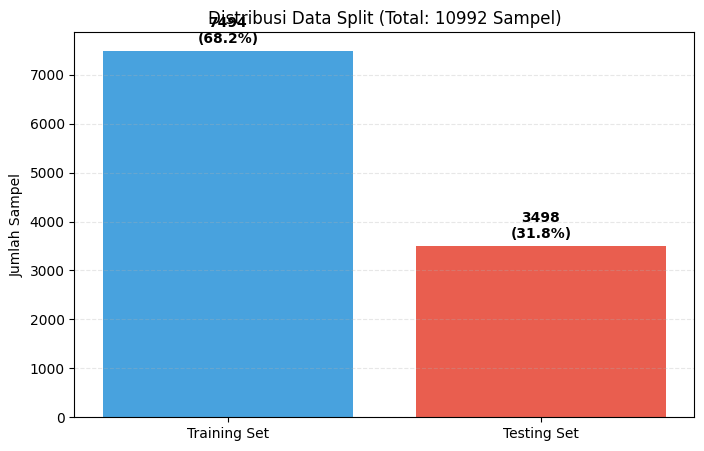

In [3]:
# =============================================#
# Visualisasi Data & Analisis Distribusi Kelas #
# =============================================#
print("\n--- ANALISIS MENDALAM: BENTUK RATA-RATA (MEAN SHAPE) ---")

unique_labels = sorted(np.unique(y_train))
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Bentuk Rata-Rata (Mean Shape) dari Seluruh Data Training', fontsize=16)

axes = axes.flatten()

for i, label in enumerate(unique_labels):
    # Ambil semua data milik kelas tersebut
    indices = np.where(y_train == label)[0]
    
    # Hitung rata-rata koordinat X dan Y untuk setiap titik (1 s/d 8)
    # X_train.iloc[indices, 0] adalah kumpulan series X
    # Kita tumpuk (stack) lalu hitung mean axis-nya
    
    all_x = np.vstack(X_train.iloc[indices, 0].values)
    all_y = np.vstack(X_train.iloc[indices, 1].values)
    
    mean_x = np.mean(all_x, axis=0)
    mean_y = np.mean(all_y, axis=0)
    
    # Plot Mean Shape (Garis Tebal Merah)
    axes[i].plot(mean_x, mean_y, 'r-o', linewidth=3, markersize=8, label='Mean Shape')
    
    # Plot beberapa sampel tipis di belakangnya sebagai bayangan (opsional, biar keren)
    for j in range(min(15, len(indices))): # Ambil 15 sampel acak
        sample_x = X_train.iloc[indices[j], 0]
        sample_y = X_train.iloc[indices[j], 1]
        axes[i].plot(sample_x, sample_y, 'k-', alpha=0.1) # Transparan
        
    axes[i].set_title(f"Mean Angka: {label}")
    axes[i].invert_yaxis()
    axes[i].axis('off')

plt.tight_layout()
plt.show()



# B. Visualisasi Perbandingan Data Train vs Test (Bar Chart)
train_count = len(X_train)
test_count = len(X_test)
total_count = train_count + test_count

plt.figure(figsize=(8, 5))
bars = plt.bar(['Training Set', 'Testing Set'], [train_count, test_count], 
               color=['#3498db', '#e74c3c'], alpha=0.9)

plt.title(f'Distribusi Data Split (Total: {total_count} Sampel)')
plt.ylabel('Jumlah Sampel')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Menambahkan label persentase di atas bar
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_count) * 100
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, 
             f"{int(height)}\n({percentage:.1f}%)", 
             ha='center', va='bottom', fontweight='bold')

plt.show()


## 3. Data Preparation


* **Pengecekan Kualitas:** Memastikan tidak ada *missing values* pada dataset.
* **Validasi Format:**
    Karena data sudah melalui proses *Spatial Resampling* menjadi 8 titik oleh penyedia dataset (sesuai penjelasan di Data Understanding), tugas utama di tahap ini adalah memuat data ke dalam struktur memori yang tepat.
* **Pembagian Data (Splitting):**
    Menggunakan **Original Split** bawaan dataset (~70:30):
    * **Training Set:** Menggunakan data dari 30 penulis pertama (7.494 sampel).
    * **Testing Set:** Menggunakan data dari 14 penulis sisanya (3.498 sampel).
    * *Alasan:* Pembagian ini disebut **"Writer-Independent"**. Model dilatih pada tulisan sekelompok orang, dan diuji pada tulisan orang yang *benar-benar baru*. Ini mensimulasikan skenario dunia nyata di mana aplikasi akan digunakan oleh user asing yang tidak ikut serta dalam pelatihan model.---


In [4]:
# ==========================================
# 3. DATA PREPARATION
# ==========================================
print("--- 3. DATA PREPARATION & QUALITY CHECK ---")

# A. Cek Missing Value
print("\n[CHECK 1] Memeriksa Missing Values...")
missing_train = X_train.isnull().sum().sum()
missing_test = X_test.isnull().sum().sum()

if missing_train == 0 and missing_test == 0:
    print("✅ Tidak ditemukan Missing Values (Clean).")
else:
    print(f"⚠️ Ditemukan Missing Values! Train: {missing_train}, Test: {missing_test}")

# B. Cek Normalisasi (Range Data) & Outlier Sederhana
# PenDigits biasanya dinormalisasi dalam range 0-100 atau 0-1
print("\n[CHECK 2] Memeriksa Range Data (Normalisasi)...")

# Mengambil semua nilai dari sampel pertama untuk cek range
sample_data = X_train.iloc[0, 0] # Dimensi 0
min_val = sample_data.min()
max_val = sample_data.max()

print(f"Range Nilai Koordinat (Sampel 1): Min={min_val}, Max={max_val}")
if 0 <= min_val and max_val <= 100:
    print("✅ Data tampak sudah dinormalisasi (Range 0-100).")
else:
    print("ℹ️ Data memiliki range di luar 0-100 (Perlu diperhatikan saat deployment).")

# C. Validasi Panjang Series (PENTING untuk Deployment)
print("\n[CHECK 3] Memeriksa Konsistensi Panjang Series...")
series_len = len(X_train.iloc[0, 0])
print(f"Panjang Series per Sampel: {series_len} titik.")
# Kita simpan info ini karena nanti aplikasi Streamlit HARUS mengubah input user jadi 8 titik juga.

--- 3. DATA PREPARATION & QUALITY CHECK ---

[CHECK 1] Memeriksa Missing Values...
✅ Tidak ditemukan Missing Values (Clean).

[CHECK 2] Memeriksa Range Data (Normalisasi)...
Range Nilai Koordinat (Sampel 1): Min=0.0, Max=100.0
✅ Data tampak sudah dinormalisasi (Range 0-100).

[CHECK 3] Memeriksa Konsistensi Panjang Series...
Panjang Series per Sampel: 8 titik.



## 4. Modeling


* **Algoritma:** **K-Nearest Neighbors (KNN)** dengan **Dynamic Time Warping (DTW)**.
* **Konfigurasi:**
    * n_neighbors = 1 (Nearest Neighbor).
    * metric = dtw (Mengukur jarak berdasarkan kemiripan bentuk pola, bukan sekadar jarak Euclidean, sehingga tahan terhadap variasi kecepatan penulisan).
* **Proses:** Model dilatih menggunakan data Training PenDigits_TRAIN.ts.


In [5]:
# ==========================================
# 4. MODELING
# ==========================================
print("--- 4. MODELING (KNN with DTW) ---")

print("Sedang melatih model")
start_time = time.time()

# Inisialisasi Model
# n_neighbors=1 dan distance='dtw' adalah setting terbaik untuk PenDigits
model = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw")

# Training
model.fit(X_train, y_train)

duration = time.time() - start_time
print(f"✅ Training Selesai! Waktu komputasi: {duration:.2f} detik.")

--- 4. MODELING (KNN with DTW) ---
Sedang melatih model


✅ Training Selesai! Waktu komputasi: 1.79 detik.



## 5. Evaluation


* **Metode:** Prediksi dilakukan terhadap PenDigits_TEST.ts.
* **Metrik Evaluasi:**
    * **Akurasi:** Persentase ketepatan prediksi keseluruhan.
    * **Confusion Matrix:** Menganalisis detail kesalahan prediksi antar kelas (misal: angka mana yang sering tertukar).
    * **Classification Report:** Melihat nilai Precision, Recall, dan F1-Score per angka.


In [6]:
# ==========================================
# 5. EVALUATION
# ==========================================
print("--- 5. EVALUATION ---")

print("Sedang melakukan prediksi data test...")
y_pred = model.predict(X_test)

# A. Akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"\n=== AKURASI MODEL: {accuracy * 100:.2f}% ===\n")

# B. Classification Report (Precision, Recall, F1-Score)
print("Detail Laporan Klasifikasi:")
print(classification_report(y_test, y_pred))

# C. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
labels = sorted(np.unique(y_train))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Prediksi vs Aktual)')
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.show()

--- 5. EVALUATION ---
Sedang melakukan prediksi data test...


KeyboardInterrupt: 


## 6. Deployment

* **Platform:** Python Web App menggunakan **Streamlit**.
* **Fitur:**
    * Integrasi **Canvas** untuk input gambar manual.
    * **Preprocessing Backend** yang mengubah gambar user menjadi format Time Series 8-titik (sama seperti data latih).
    * Menggunakan model tersimpan (.pkl) untuk inferensi *real-time*.

In [33]:
# ==========================================
# 6. DEPLOYMENT PREPARATION
# ==========================================
print("--- 6. SAVE MODEL ---")

filename = "pendigits_model_final.pkl"
joblib.dump(model, filename)

print(f"✅ Model berhasil disimpan ke file: '{filename}'")
print("File ini siap digunakan untuk Backend Aplikasi Streamlit.")

--- 6. SAVE MODEL ---
✅ Model berhasil disimpan ke file: 'pendigits_model_final.pkl'
File ini siap digunakan untuk Backend Aplikasi Streamlit.
